# Retrieval-Augmented Generation(RAG) using IBM Watsonx

In this notebook, we will build a Retrieval-Augmented Generation(RAG) using IBM Watsonx embeddings and GPT 3.5 LLM .

RAG is a technique that retrieves related documents to the user's question, combines them with LLM-base prompt, and sends them to LLMs like GPT to produce more factually accurate generation.

In this example, we'll use `DeadPool and Wolverine` marvel page to build RAG around it.

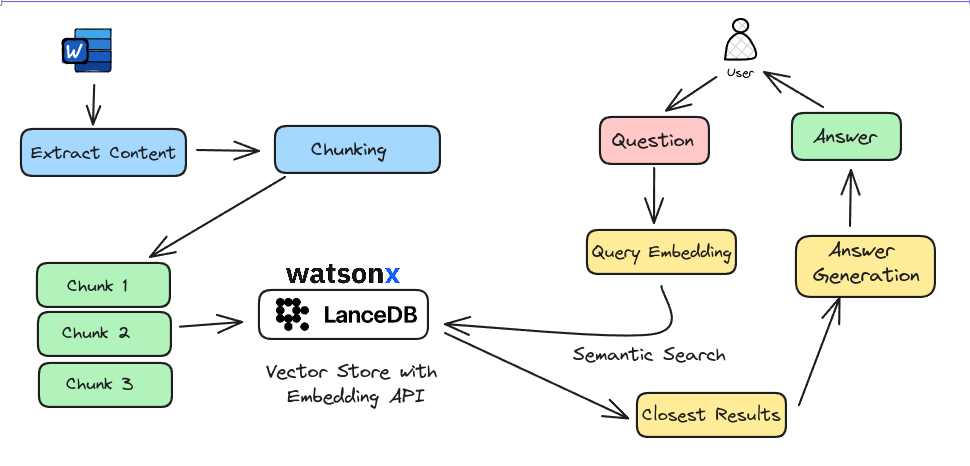

## Install Dependencies

In [ ]:
# install lancedb and ibm-watson
!pip install ibm-watsonx-ai lancedb -q

In [ ]:
# install llama-index and web-reader
!pip install llama_index llama-index-readers-web -q

## Load documents from webpage

In [ ]:
# Load data
import argparse
from llama_index.core import VectorStoreIndex, Settings, StorageContext
from llama_index.readers.web import SimpleWebPageReader


def get_doc_from_url(url):
    """
    Load data from a url
    """
    documents = SimpleWebPageReader(html_to_text=True).load_data([url])
    return documents

In [ ]:
# documents
url = "https://marvelcinematicuniverse.fandom.com/wiki/Deadpool_%26_Wolverine"
documents = get_doc_from_url(url)
print(len(documents))

1


## Chunking

In [ ]:
from llama_index.core.node_parser import SentenceSplitter

# splitting extracted document into chunks
splitter = SentenceSplitter(
    chunk_size=1024,
    chunk_overlap=20,
)
nodes = splitter.get_nodes_from_documents(documents)
nodes[0].text

'# Marvel Cinematic Universe Wiki\n\nWith the release of _[Deadpool& Wolverine](/wiki/Deadpool_%26_Wolverine\n"Deadpool & Wolverine")_ we\'d like to remind the community of some things.\nPlease DO NOT add info from the Fox X-Men movies when it comes to pages. Only\ninformation stated within the movie itself is eligible to be added. In\naddition, do not upload pirated images from cam copies. We\'d also like to ask\nthat universe pages NOT be created if the universe name has a Placeholder\ntemplate on it, as that indicates it is not the intended final name. Thank\nyou.\n\nREAD MORE\n\n[ ![Marvel Cinematic Universe\nWiki](https://static.wikia.nocookie.net/marvelcinematicuniverse/images/e/e6/Site-\nlogo.png/revision/latest?cb=20220123055921)\n](//marvelcinematicuniverse.fandom.com) [Marvel Cinematic Universe\nWiki](//marvelcinematicuniverse.fandom.com)\n\n  * Explore\n\n    * [ Main Page ](https://marvelcinematicuniverse.fandom.com/wiki/Marvel_Cinematic_Universe_Wiki)\n    * [ Discuss ](/f

## Set Watson and OpenAI creds as env variable

In [ ]:
import os

# set watson api key and project id and OpenAI key as env variable
os.environ["WATSONX_API_KEY"] = "...."
os.environ["WATSONX_PROJECT_ID"] = "..."

os.environ["OPENAI_API_KEY"] = "sk-proj-..."

In [ ]:
# check for all env variables set or not
if os.environ.get("OPENAI_API_KEY") is not None:
    print("OPENAI_API_KEY is already set")
else:
    raise KeyError("OPENAI_API_KEY is not set as an env variable")

if os.environ.get("WATSONX_API_KEY") is not None:
    print("WATSONX_API_KEY is already set")
else:
    raise KeyError("WATSONX_API_KEY is not set as an env variable")

if os.environ.get("WATSONX_PROJECT_ID") is not None:
    print("WATSONX_PROJECT_ID is already set")
else:
    raise KeyError("WATSONX_PROJECT_ID is not set as an env variable")

OPENAI_API_KEY is already set
WATSONX_API_KEY is already set
WATSONX_PROJECT_ID is already set


## Define custom Embedding function for watsonx model

In [ ]:
from lancedb.embeddings.registry import register
from lancedb.util import attempt_import_or_raise
from functools import cached_property
from lancedb.embeddings.base import TextEmbeddingFunction

from ibm_watsonx_ai import Credentials
from ibm_watsonx_ai.foundation_models import Embeddings
from ibm_watsonx_ai.metanames import EmbedTextParamsMetaNames as EmbedParams
from ibm_watsonx_ai.foundation_models.utils.enums import EmbeddingTypes

# define IBM watsonx Embedding function


@register("ibm-watsonx")
class WatsonEmbeddings(TextEmbeddingFunction):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._ndims = None
        self._embed_params = {
            EmbedParams.TRUNCATE_INPUT_TOKENS: 3,
            EmbedParams.RETURN_OPTIONS: {"input_text": True},
        }
        self._watson_api_key = os.environ.get("WATSONX_API_KEY")
        self._watson_project_id = os.environ.get("WATSONX_PROJECT_ID")
        self._watson_credentials = Credentials(
            api_key=self._watson_api_key, url="https://us-south.ml.cloud.ibm.com"
        )

    def generate_embeddings(self, texts):
        model = Embeddings(
            model_id=EmbeddingTypes.IBM_SLATE_30M_ENG,
            params=self._embed_params,
            credentials=self._watson_credentials,
            project_id=self._watson_project_id,
        )
        return model.embed_documents(texts=list(texts))

    def ndims(self):
        if self._ndims is None:
            self._ndims = len(self.generate_embeddings(texts=["foo"])[0])
        return self._ndims

## Create Table

In [ ]:
import os
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import EmbeddingFunctionRegistry

# create a table with above defined embedding function
watsonx_embed = EmbeddingFunctionRegistry.get_instance().get("ibm-watsonx").create()


# schema of table
class TextModel(LanceModel):
    text: str = watsonx_embed.SourceField()
    vector: Vector(watsonx_embed.ndims()) = watsonx_embed.VectorField()


# data chunks
data = []
for node in nodes:
    data.append({"text": node.text})

db = lancedb.connect("~/.lancedb")
tbl = db.create_table("watsonx_test", schema=TextModel, mode="overwrite")

tbl.add(data)

## Query
Query ingested webpage

In [ ]:
query = "role of deadpool"
result = tbl.search(query).limit(5).to_list()

In [ ]:
context = [r["text"] for r in result]
print(context)

['Despite\nDeadpool\'s antagonism towards Nicepool, the latter gives them directions to\nthe Void\'s borderlands and provides them with a car to make it there. While\ndriving, Deadpool accidentally slips up that he is not certain that the TVA\nwill fix Wolverine\'s reality, admitting that he made an "educated wish".\nWolverine is enraged and lashes out at Deadpool, which results in both of them\nfighting each other until both are too exhausted, and someone drives their car\nto the Resistance hideout.\n\n[![Deadpool & Wolverine Trailer\n\\(64\\)](data:image/gif;base64,R0lGODlhAQABAIABAAAAAP///yH5BAEAAAEALAAAAAABAAEAQAICTAEAOw%3D%3D)](https://static.wikia.nocookie.net/marvelcinematicuniverse/images/1/13/Deadpool_%26_Wolverine_Trailer_%2864%29.png/revision/latest?cb=20240422182040)\n[![Deadpool & Wolverine Trailer\n\\(64\\)](https://static.wikia.nocookie.net/marvelcinematicuniverse/images/1/13/Deadpool_%26_Wolverine_Trailer_%2864%29.png/revision/latest/scale-\nto-width-\ndown/250?cb=20240

## LLM using Chain
Set up a process where you use a prompt and OpenAI's language model to generate responses based on the content of the documents you provide.

In [ ]:
# Context Prompt

base_prompt = """You are an AI assistant. Your task is to understand the user question, and provide an answer using the provided contexts. Every answer you generate should have citations in this pattern  "Answer [position].", for example: "Earth is round [1][2].," if it's relevant.

Your answers are correct, high-quality, and written by an domain expert. If the provided context does not contain the answer, simply state, "The provided context does not have the answer."

User question: {}

Contexts:
{}
"""

In [ ]:
import openai

# OpenAI chat completion for using context provided and generating answer
prompt = f"{base_prompt.format(query, context)}"
response = openai.chat.completions.create(
    model="gpt-3.5-turbo",
    temperature=0,
    messages=[
        {"role": "system", "content": prompt},
    ],
)

print(response.choices[0].message.content)

The role of Deadpool in the events described involves teaming up with Wolverine and other characters to take on Nova and avenge Storm's death. Deadpool plays a crucial part in convincing the Resistance to join forces and confront Nova, ultimately leading to the destruction of the Time Ripper and Nova's demise. Despite Deadpool's initial intention to sacrifice himself, Wolverine also plays a significant role in the final act, resulting in both characters surviving the ordeal and being commended for their actions by B-15 and the TVA [1].


## Conclusion

By the end of this example, we’ve created a Retrieval-Augmented Generation (RAG) system for webpages. We showed how it works with pages about `Deadpool and Wolverine` from Marvel. Here’s how we did it in 4 simple steps:

1. Load data from the webpage.
2. Create a custom embedding function with IBM Watsonx.
3. Add the loaded documents into a table with their embeddings.
4. Use ChatChain to generate answers based on the retrieved documents.